### Imports

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Macros

In [4]:
datapath = "processed_deck_data.csv"
hidden_layers =  (50, 40, 30, 20, 10) # hidden layers
input_size = 0
num_epochs = 502 # number of epochs to train

# Get Data
### already preprocessed, must be all numeric

In [5]:
df = pd.read_csv(datapath)

# last column is the label
X = df.iloc[:, :-1].values  # features

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # fit and transform the features

Y = df.iloc[:, -1].values   # labels

X_train_np, X_test_np, Y_train_np, Y_test_np = train_test_split(X, Y)

# Convert to torch tensors
X_train = torch.tensor(X_train_np).float() # dtype=torch.float32
Y_train = torch.tensor(Y_train_np).float()
X_test = torch.tensor(X_test_np).float()
Y_test = torch.tensor(Y_test_np).float()

# determine size of input space
input_size = X_train.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: 'processed_deck_data.csv'

In [72]:
len(X), float(np.average(Y))

(2823527, 0.4938918593659632)

# Build Neural Network

In [6]:
layers = list()

if len(hidden_layers) == 0:
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
else:
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_layers)):
        layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    layers.append(nn.Sigmoid())

model = nn.Sequential(*layers)

# prepare for training
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

C:\Users\ferr\AppData\Local\JetBrains\PyCharm2024.2\demo\PyCharmLearningProject\venv\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [7]:
[model.parameters().__next__() for i in range(10)]

[Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True),
 Parameter containing:
 tensor([], size=(50, 0), requires_grad=True)]

# Define Train Loop

In [8]:
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    Y_pred = model(X_train).flatten()
    loss = loss_fn(Y_pred, Y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        with torch.inference_mode():
            # Test the model
            Y_test_pred = model(X_test).flatten()
            test_loss = loss_fn(Y_test_pred, Y_test)

            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
            print("Y_pred:", Y_pred)

NameError: name 'X_train' is not defined

In [83]:
model.eval()
print("Y_pred:")
print(model(X_test).flatten())
print("Y_test:")
print(Y_test)
# print(model.state_dict())


Y_pred:
tensor([0.4887, 0.4926, 0.5065,  ..., 0.5125, 0.4830, 0.4890],
       grad_fn=<ViewBackward0>)
Y_test:
tensor([1., 1., 1.,  ..., 0., 1., 1.])
OrderedDict({'0.weight': tensor([[-0.0053, -0.0999,  0.0324,  0.2127, -0.1188, -0.1912,  0.1822,  0.1573,
         -0.0060,  0.0216,  0.1796,  0.0473, -0.0767,  0.1581, -0.1607,  0.1433],
        [-0.1923,  0.0925,  0.2439,  0.1020,  0.0842,  0.0746,  0.2560, -0.2109,
         -0.2275, -0.1235,  0.2564,  0.0793,  0.0339, -0.1457,  0.1290,  0.0187],
        [-0.1797, -0.0828,  0.0351, -0.0851,  0.0557,  0.1956, -0.2003,  0.2219,
         -0.0390, -0.0080,  0.2012, -0.1874,  0.0167, -0.2358, -0.0748, -0.1331],
        [ 0.2473, -0.0880,  0.0683,  0.1649, -0.1583,  0.0449, -0.1186,  0.0582,
          0.2242,  0.0285, -0.0706, -0.2442,  0.2247,  0.1879,  0.0163,  0.1318],
        [ 0.0353,  0.0531, -0.2751,  0.0453, -0.2448, -0.0533,  0.1161,  0.2144,
         -0.0307, -0.0735, -0.2822,  0.1598,  0.1318, -0.0900,  0.2215, -0.1448],
        [-

# Save Model & Data

In [85]:
import os
from datetime import datetime
import json
import shutil

def save_model_run(model, datapath, hidden_layers, input_size, num_epochs,
                  train_loss_values, test_loss_values, epoch_count):
    # Create a timestamped folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"model_run_{timestamp}"
    os.makedirs(folder_name, exist_ok=True)

    # Save model weights
    model_path = os.path.join(folder_name, "model_weights.pth")
    torch.save(model.state_dict(), model_path)

    # save model for netron
    traced_model = torch.jit.trace(model, torch.randn(1, input_size))
    traced_model.save(os.path.join(folder_name, "model.pt"))

    # Save configuration details
    config = {
        "datapath": datapath,
        "hidden_layers": hidden_layers,
        "input_size": input_size,
        "num_epochs": num_epochs,
        "timestamp": timestamp,
        "learning_rate": optimizer.param_groups[0]['lr']
    }

    with open(os.path.join(folder_name, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)

    # Save loss values
    loss_data = {
        "epochs": epoch_count,
        "train_loss": train_loss_values,
        "test_loss": test_loss_values
    }
    np.savez(os.path.join(folder_name, "loss_data.npz"), **loss_data)

    # Save plots
    # Loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_count, train_loss_values, label="Train loss")
    plt.plot(epoch_count, test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.savefig(os.path.join(folder_name, "loss_curves.png"))
    plt.close()

    # Calculate and save confusion matrix
    model.eval()
    with torch.no_grad():
        Y_test_pred = model(X_test).flatten()
        predicted_classes = (Y_test_pred >= 0.5).float()
        cm = confusion_matrix(Y_test.numpy(), predicted_classes.numpy())
        accuracy = accuracy_score(Y_test.numpy(), predicted_classes.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Win'],
                yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.4f})')
    plt.savefig(os.path.join(folder_name, "confusion_matrix.png"))
    plt.close()

    # Calculate and save feature importance
    importance = compute_feature_importance_simple(model, X_test_np)
    feature_names = df.columns[:-1]

    plt.figure(figsize=(12, 8))
    importance_sorted_idx = np.argsort(importance)
    plt.barh(range(len(importance)), importance[importance_sorted_idx])
    plt.yticks(range(len(importance)), [feature_names[i] for i in importance_sorted_idx])
    plt.title('Feature Importance')
    plt.xlabel('Mean Absolute Difference in Predictions')
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, "feature_importance.png"))
    plt.close()

    # Copy notebook to the folder if it exists
    try:
        shutil.copy("neural_sketwork.ipynb", os.path.join(folder_name, "neural_sketwork.ipynb"))
    except:
        pass

    print(f"Model and related information saved to folder: {folder_name}")
    return folder_name

# Call the function after training
save_folder = save_model_run(model, datapath, hidden_layers, input_size, num_epochs,
                           train_loss_values, test_loss_values, epoch_count)

Model and related information saved to folder: model_run_20250702_161348


# Make Predictions

In [52]:
model.eval()
with torch.inference_mode():

    # Find our model's learned parameters
    from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
    print("The model learned the following values for weights and bias:")
    pprint(model.state_dict())
    print("\nAnd the original values for weights and bias are:")
    pprint(f"weights: {layers[-2]}")

The model learned the following values for weights and bias:
OrderedDict([('0.weight',
              tensor([[-0.0051, -0.0994,  0.0323,  0.2134, -0.1181, -0.1924,  0.1829,  0.1561,
         -0.0061,  0.0213,  0.1792,  0.0473, -0.0761,  0.1587, -0.1608,  0.1427],
        [-0.1917,  0.0917,  0.2442,  0.1030,  0.0842,  0.0747,  0.2559, -0.2108,
         -0.2277, -0.1243,  0.2563,  0.0788,  0.0341, -0.1465,  0.1292,  0.0178],
        [-0.1805, -0.0815,  0.0355, -0.0842,  0.0545,  0.1957, -0.2016,  0.2220,
         -0.0378, -0.0086,  0.1991, -0.1860,  0.0187, -0.2342, -0.0757, -0.1314],
        [ 0.2470, -0.0866,  0.0674,  0.1655, -0.1586,  0.0451, -0.1189,  0.0584,
          0.2249,  0.0279, -0.0709, -0.2435,  0.2246,  0.1876,  0.0157,  0.1331],
        [ 0.0356,  0.0535, -0.2747,  0.0457, -0.2457, -0.0534,  0.1152,  0.2143,
         -0.0305, -0.0737, -0.2819,  0.1601,  0.1317, -0.0905,  0.2219, -0.1443],
        [-0.1742,  0.1455,  0.1854, -0.0760,  0.2242,  0.1001,  0.1993,  0.1501,
   

# Plot Predictions

Large preprocessed dataset, scaled


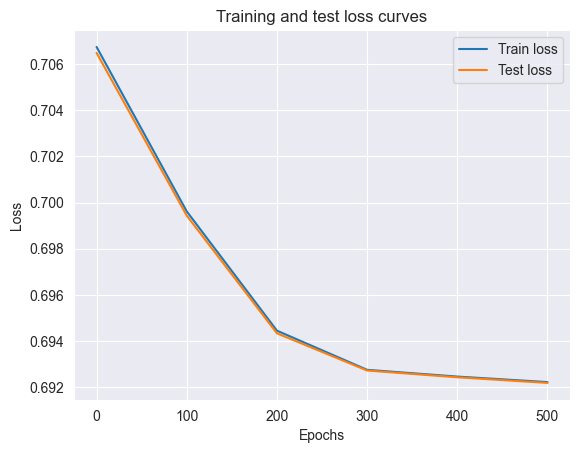

In [53]:
# Plot the loss curves
print("Large preprocessed dataset, scaled")
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [54]:
# train_loss_values, test_loss_values, epoch_count

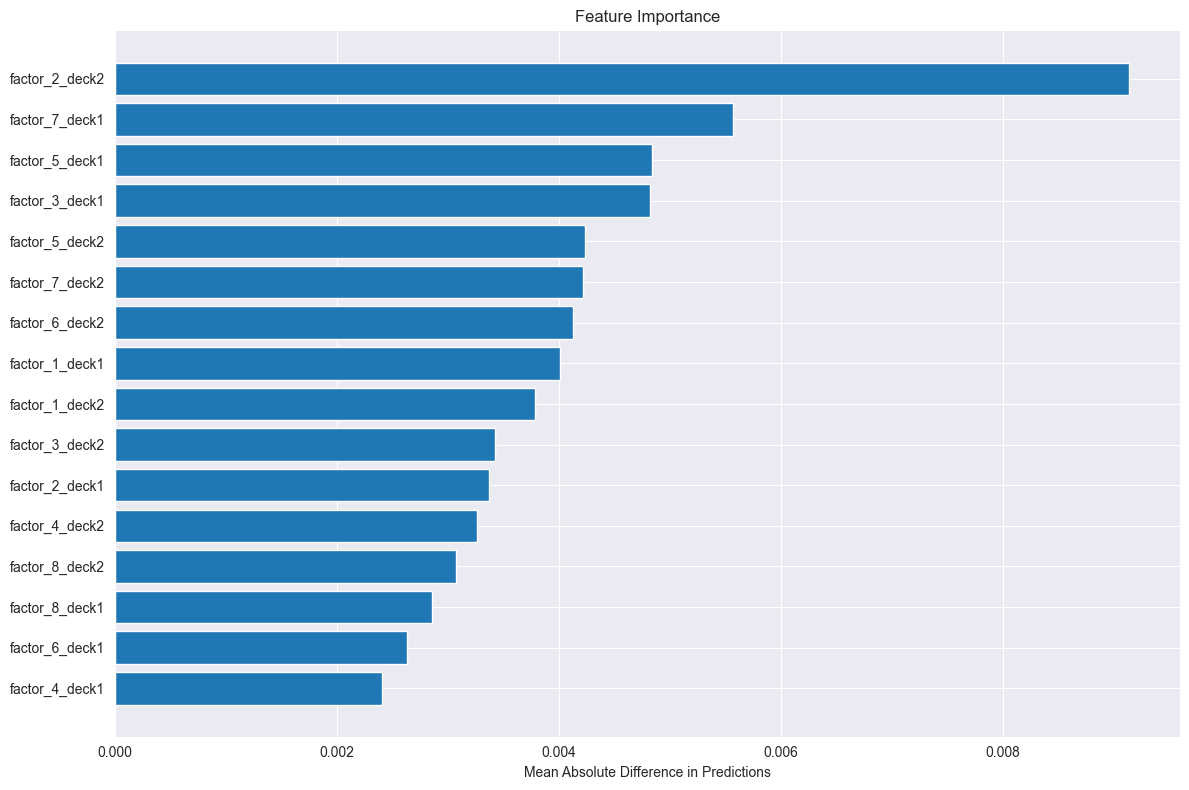

In [55]:
# Simpler feature importance method that works well with neural networks
def compute_feature_importance_simple(model, X, n_repeats=5):
    """Calculate feature importance by measuring impact of shuffling each feature"""
    importance = np.zeros(X.shape[1])
    model.eval()

    # Get baseline prediction
    X_tensor = torch.tensor(X).float()
    with torch.no_grad():
        baseline_preds = model(X_tensor).flatten().numpy()

    # For each feature
    for i in range(X.shape[1]):
        feature_importance = 0

        # Repeat the process multiple times
        for _ in range(n_repeats):
            # Create a copy of X with the feature shuffled
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])

            # Get predictions with shuffled feature
            X_permuted_tensor = torch.tensor(X_permuted).float()
            with torch.no_grad():
                permuted_preds = model(X_permuted_tensor).flatten().numpy()

            # Calculate importance as the decrease in performance
            feature_importance += np.mean(np.abs(baseline_preds - permuted_preds))

        importance[i] = feature_importance / n_repeats

    return importance

# Calculate feature importance
importance = compute_feature_importance_simple(model, X_test_np)

# Get feature names from dataframe
feature_names = df.columns[:-1]  # Exclude the target column

# Plot feature importance
plt.figure(figsize=(12, 8))
importance_sorted_idx = np.argsort(importance)
plt.barh(range(len(importance)), importance[importance_sorted_idx])
plt.yticks(range(len(importance)), [feature_names[i] for i in importance_sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Mean Absolute Difference in Predictions')
plt.tight_layout()
plt.show()

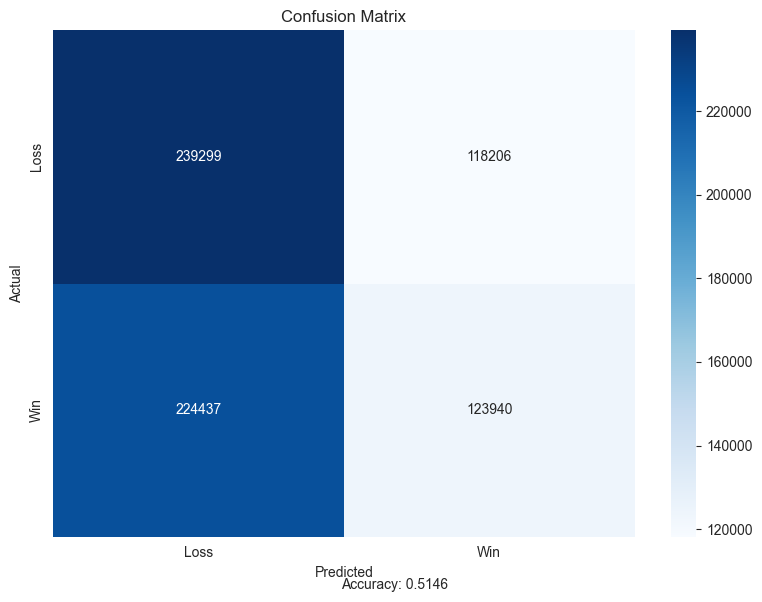

In [56]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(model, X_test, Y_test, threshold=0.5):
    # Get predictions from the model
    model.eval()
    with torch.no_grad():
        Y_test_pred = model(X_test).flatten()
        # Convert probabilities to binary predictions using threshold
        predicted_classes = (Y_test_pred >= threshold).float()

    # Convert tensors to numpy for sklearn
    y_true = Y_test.numpy()
    y_pred = predicted_classes.numpy()

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix with seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Win'],
                yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Calculate and display accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

# Call the function with your model
plot_confusion_matrix(model, X_test, Y_test)

In [58]:
datapath = "processed_example.csv"
df = pd.read_csv(datapath)

# last column is the label
X = df.iloc[:, :-1].values  # features

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # fit and transform the features

# Convert to torch tensors
X = torch.tensor(X).float()

In [61]:
Y_pred = model(X).flatten()
Y_pred

tensor([0.4513], grad_fn=<ViewBackward0>)